In [1]:
!pip install --quiet keras tqdm

In [24]:
import os
import time
import tensorflow as tf
import numpy as np
from glob import glob
import datetime
import random
from PIL import Image
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras import layers
from keras.layers import Input, Dense, Reshape, Flatten, Embedding, Dropout, UpSampling2D
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2DTranspose, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils.generic_utils import Progbar

# from tqdm import tqdm
%matplotlib inline

In [9]:
# Hyperparameters
IMAGE_SIZE = 128
NOISE_SIZE = 100
LR_D = 0.00004
LR_G = 0.0004
BATCH_SIZE = 16#64
EPOCHS = 1
BETA1 = 0.5
WEIGHT_INIT_STDDEV = 0.02
EPSILON = 0.00005
SAMPLES_TO_SHOW = 5

In [10]:
# Paths
INPUT_DATA_DIR = "./classes/deep_learning/data/simpsons_faces/" # Path to the folder with input images. For more info check simspons_dataset.txt
OUTPUT_DIR = './classes/deep_learning/data/tensorflow{date:%Y-%m-%d_%H:%M:%S}/'.format(date=datetime.datetime.now())
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    
input_images = np.asarray([np.asarray(Image.open(file).resize((IMAGE_SIZE, IMAGE_SIZE))) for file in glob(INPUT_DATA_DIR + '*')])
print ("Input: " + str(input_images.shape))

np.random.shuffle(input_images)

Input: (9877, 128, 128, 3)


In [11]:
small_images = input_images[:16*2,:,:,:]

In [20]:
def create_discriminator():
  discriminator = Sequential()

  # 128*128*3 -> 64x64x64 
  discriminator.add(Conv2DTranspose(64, kernel_size=[5,5], strides=[2,2], padding='same', kernel_initializer='glorot_normal', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
  discriminator.add(BatchNormalization(epsilon=EPSILON))
  discriminator.add(LeakyReLU())
  
  # 64x64x64-> 32x32x128 
  discriminator.add(Conv2DTranspose(128, kernel_size=[5,5], strides=[2,2], padding='same', kernel_initializer='glorot_normal'))
  discriminator.add(BatchNormalization(epsilon=EPSILON))
  discriminator.add(LeakyReLU())
  
  # 32x32x128 -> 16x16x256
  discriminator.add(Conv2DTranspose(256, kernel_size=[5,5], strides=[2,2], padding='same', kernel_initializer='glorot_normal'))
  discriminator.add(BatchNormalization(epsilon=EPSILON))
  discriminator.add(LeakyReLU())
  
  # 16x16x256 -> 16x16x512
  discriminator.add(Conv2DTranspose(512, kernel_size=[5,5], strides=[1,1], padding='same', kernel_initializer='glorot_normal'))
  discriminator.add(BatchNormalization(epsilon=EPSILON))
  discriminator.add(LeakyReLU())
  
  # 16x16x512 -> 8x8x1024
  discriminator.add(Conv2DTranspose(1024, kernel_size=[5,5], strides=[2,2], padding='same', kernel_initializer='glorot_normal'))
  discriminator.add(BatchNormalization(epsilon=EPSILON))
  discriminator.add(LeakyReLU())
  
  discriminator.add(Flatten())
  discriminator.add(Dense(units=1, activation='sigmoid'))
  
  discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=LR_D, beta_1=BETA1))
  return discriminator
def create_generator():
  generator = Sequential()
  
  # 8x8x1024
  generator.add(Dense(8*8*1024, input_dim=NOISE_SIZE, kernel_initializer='glorot_normal'))
  generator.add(Reshape((8, 8, 1024)))
  generator.add(LeakyReLU())
  
  # 8x8x1024 -> 16x16x512
  generator.add(Conv2DTranspose(512, kernel_size=[5,5], strides=[2,2], padding='same', kernel_initializer='glorot_normal'))
  generator.add(BatchNormalization(epsilon=EPSILON))
  generator.add(LeakyReLU())
  
  # 16x16x512 -> 32x32x256
  generator.add(Conv2DTranspose(256, kernel_size=[5,5], strides=[2,2], padding='same', kernel_initializer='glorot_normal'))
  generator.add(BatchNormalization(epsilon=EPSILON))
  generator.add(LeakyReLU())
  
  # 32x32x256 -> 64x64x128
  generator.add(Conv2DTranspose(128, kernel_size=[5,5], strides=[2,2], padding='same', kernel_initializer='glorot_normal'))
  generator.add(BatchNormalization(epsilon=EPSILON))
  generator.add(LeakyReLU())
  
  # 64x64x128 -> 128x128x64
  generator.add(Conv2DTranspose(64, kernel_size=[5,5], strides=[2,2], padding='same', kernel_initializer='glorot_normal'))
  generator.add(BatchNormalization(epsilon=EPSILON))
  generator.add(LeakyReLU())
  
  # 128x128x64 -> 128x128x3
  generator.add(Conv2DTranspose(3, kernel_size=[5,5], strides=[1,1], padding='same', activation='tanh', kernel_initializer='glorot_normal'))
  
  generator.compile(loss='binary_crossentropy', optimizer=Adam(lr=LR_G, beta_1=BETA1))
  return generator

def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(NOISE_SIZE,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan
  
def model_loss(input_real, input_z, output_channel_dim):
    g_model = generator(input_z, output_channel_dim, True)

    noisy_input_real = input_real + tf.random_normal(shape=tf.shape(input_real),
                                                     mean=0.0,
                                                     stddev=random.uniform(0.0, 0.1),
                                                     dtype=tf.float32)
    
    d_model_real, d_logits_real = discriminator(noisy_input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_model_real)*random.uniform(0.9, 1.0)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_model_fake)))
    d_loss = tf.reduce_mean(0.5 * (d_loss_real + d_loss_fake))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_model_fake)))
    return d_loss, g_loss
  
def model_optimizers(d_loss, g_loss):
  t_vars = tf.trainable_variables()
  g_vars = [var for var in t_vars if var.name.startswith("generator")]
  d_vars = [var for var in t_vars if var.name.startswith("discriminator")]

  update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
  gen_updates = [op for op in update_ops if op.name.startswith('generator')]

  with tf.control_dependencies(gen_updates):
      d_train_opt = tf.train.AdamOptimizer(learning_rate=LR_D, beta1=BETA1).minimize(d_loss, var_list=d_vars)
      g_train_opt = tf.train.AdamOptimizer(learning_rate=LR_G, beta1=BETA1).minimize(g_loss, var_list=g_vars)  
  return d_train_opt, g_train_opt
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate_G = tf.placeholder(tf.float32, name="lr_g")
    learning_rate_D = tf.placeholder(tf.float32, name="lr_d")
    return inputs_real, inputs_z, learning_rate_G, learning_rate_D
def show_samples(sample_images, name, epoch):
    figure, axes = plt.subplots(1, len(sample_images), figsize = (IMAGE_SIZE, IMAGE_SIZE))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample_images[index]
        axis.imshow(image_array)
        image = Image.fromarray(image_array)
        image.save(name+"_"+str(epoch)+"_"+str(index)+".png") 
    plt.savefig(name+"_"+str(epoch)+".png", bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()
def test(sess, input_z, out_channel_dim, epoch):
    example_z = np.random.uniform(-1, 1, size=[SAMPLES_TO_SHOW, input_z.get_shape().as_list()[-1]])
    samples = sess.run(generator(input_z, out_channel_dim, False), feed_dict={input_z: example_z})
    sample_images = [((sample + 1.0) * 127.5).astype(np.uint8) for sample in samples]
    show_samples(sample_images, OUTPUT_DIR + "samples", epoch)
def summarize_epoch(epoch, duration, sess, d_losses, g_losses, input_z, data_shape):
    minibatch_size = int(data_shape[0]//BATCH_SIZE)
    print("Epoch {}/{}".format(epoch, EPOCHS),
          "\nDuration: {:.5f}".format(duration),
          "\nD Loss: {:.5f}".format(np.mean(d_losses[-minibatch_size:])),
          "\nG Loss: {:.5f}".format(np.mean(g_losses[-minibatch_size:])))
    fig, ax = plt.subplots()
    plt.plot(d_losses, label='Discriminator', alpha=0.6)
    plt.plot(g_losses, label='Generator', alpha=0.6)
    plt.title("Losses")
    plt.legend()
    plt.savefig(OUTPUT_DIR + "losses_" + str(epoch) + ".png")
    plt.show()
    plt.close()
    test(sess, input_z, data_shape[3], epoch)
def get_batches(data):
    batches = []
    for i in range(int(data.shape[0]//BATCH_SIZE)):
        batch = data[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]
        augmented_images = []
        for img in batch:
            image = Image.fromarray(img)
            if random.choice([True, False]):
                image = image.transpose(Image.FLIP_LEFT_RIGHT)
            augmented_images.append(np.asarray(image))
        batch = np.asarray(augmented_images)
        normalized_batch = (batch / 127.5) - 1.0
        batches.append(normalized_batch)
    return batches
def train(get_batches, data_shape, checkpoint_to_load=None):
    input_images, input_z, lr_G, lr_D = model_inputs(data_shape[1:], NOISE_SIZE)
    d_loss, g_loss = model_loss(input_images, input_z, data_shape[3])
    d_opt, g_opt = model_optimizers(d_loss, g_loss)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        epoch = 0
        iteration = 0
        d_losses = []
        g_losses = []
        
        for epoch in range(EPOCHS):
            epoch += 1
            start_time = time.time()

            for batch_images in get_batches:
                iteration += 1
                batch_z = np.random.uniform(-1, 1, size=(BATCH_SIZE, NOISE_SIZE))
                _ = sess.run(d_opt, feed_dict={input_images: batch_images, input_z: batch_z, lr_D: LR_D})
                _ = sess.run(g_opt, feed_dict={input_images: batch_images, input_z: batch_z, lr_G: LR_G})
                d_losses.append(d_loss.eval({input_z: batch_z, input_images: batch_images}))
                g_losses.append(g_loss.eval({input_z: batch_z}))

            summarize_epoch(epoch, time.time()-start_time, sess, d_losses, g_losses, input_z, data_shape)
            
# train(get_batches(small_images), small_images.shape)

def plot_generated_images(epoch, generator, examples=5, dim=(4, 4), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, NOISE_SIZE])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, IMAGE_SIZE, IMAGE_SIZE)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    

In [19]:
def train_datalab(get_batches):
    # Get the training and testing data
    #     x_train, y_train, x_test, y_test = load_minst_data()
        
        # Split the training data into batches of size 128
    #     batch_count = x_train.shape[0] / batch_size
    
        # Build our GAN netowrk
    #     adam = get_optimizer()
    
    generator = create_generator()
    discriminator = create_discriminator()
    gan = create_gan(discriminator, generator)
    debug = True
    for epoch in range(EPOCHS):
        epoch += 1
        start_time = time.time()
        if debug: print('Starting epoch')
        for batch_images in get_batches:
            # Get a random set of input noise and images
    #             noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            batch_z = np.random.uniform(-1, 1, size=(BATCH_SIZE, NOISE_SIZE))
    
    #             image_batch = x_train[np.random.randint(0, x_train.shape[0], size=BATCH_SIZE)]
            image_batch = batch_images
            # Generate fake MNIST images
            if debug: print('Generating fake images')
            generated_images = generator.predict(batch_z)
            print('Generated fake images')
            X = np.concatenate([image_batch, generated_images])
    
            # Labels for generated and real data
            y_dis = np.zeros(2*BATCH_SIZE)
            # One-sided label smoothing
            y_dis[:BATCH_SIZE] = 0.9
    
            # Train discriminator
            if debug: print('Training discriminator')
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)
    
            # Train generator
            if debug: print('Training generator')
            batch_z = np.random.normal(0, 1, size=[BATCH_SIZE, NOISE_SIZE])
            y_gen = np.ones(BATCH_SIZE)
            discriminator.trainable = False
            gan.train_on_batch(batch_z, y_gen)
    
    #         summarize_epoch(epoch, time.time()-start_time, sess, d_losses, g_losses, input_z, data_shape)
    #         if e == 1 or e % 20 == 0:
            plot_generated_images(epoch, generator)
# train_datalab(get_batches(small_images))

NameError: name 'create_generator' is not defined

In [21]:
generator = create_generator()
discriminator = create_discriminator()
gan = create_gan(discriminator, generator)

In [22]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 65536)             6619136   
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 1024)        0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 1024)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 512)       13107712  
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 512)       2048      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 256)       3277056   
__________

In [13]:
import gc; gc.collect()

171

In [ ]:
batch_z = np.random.uniform(-1, 1, size=(BATCH_SIZE, NOISE_SIZE))
prediction = generator.predict(batch_z)

In [42]:
prediction.shape

(1, 128, 128, 3)

In [26]:
small_images.shape

(512, 128, 128, 3)

In [19]:
train_datalab(get_batches(small_images))

Instructions for updating:
Colocations handled automatically by placer.
Starting epoch
Generating fake images
Training discriminator
Instructions for updating:
Use tf.cast instead.


KeyboardInterrupt: 

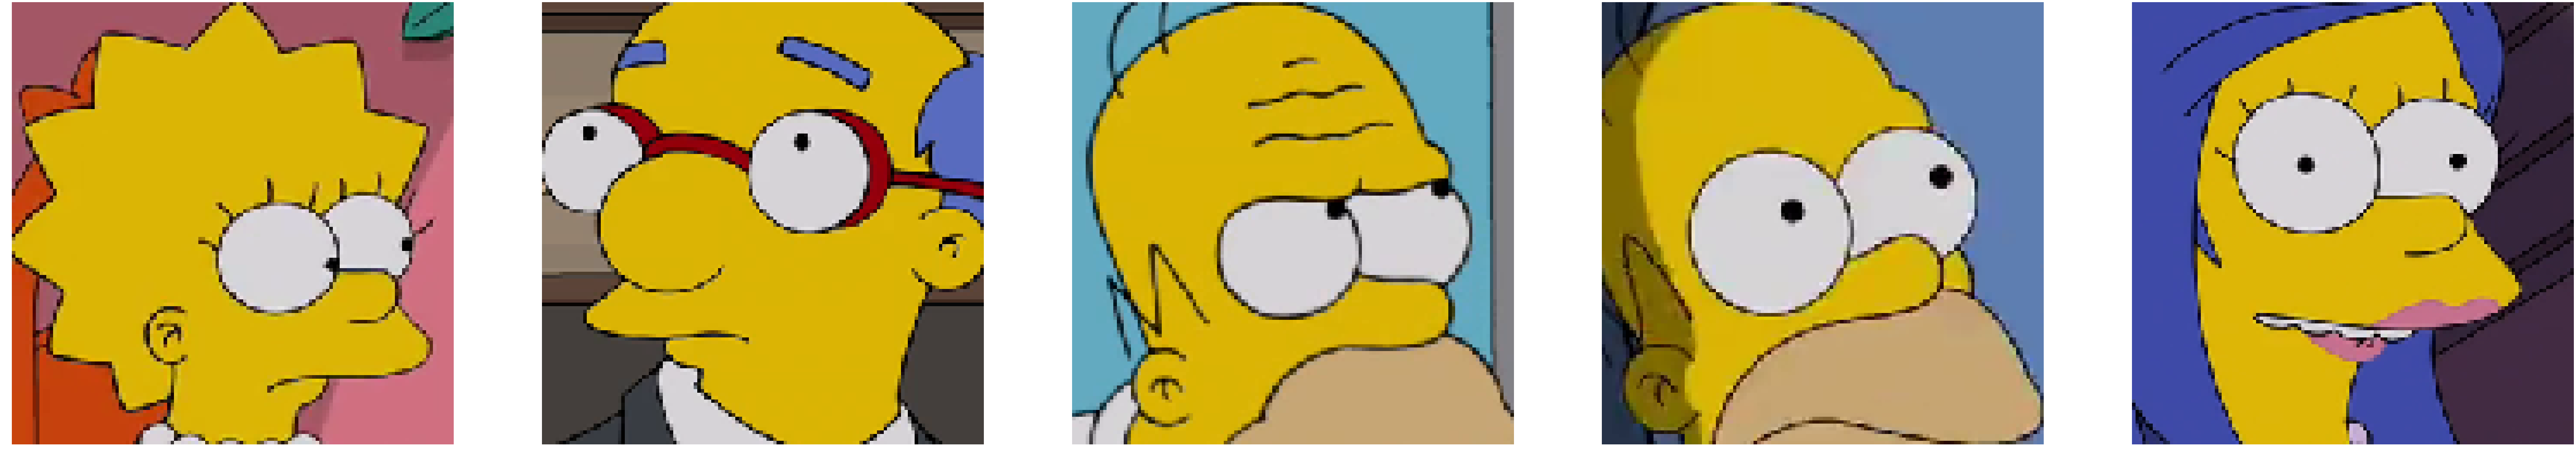

In [10]:
sample_images = random.sample(list(input_images), SAMPLES_TO_SHOW)
show_samples(sample_images, OUTPUT_DIR + "inputs", 0)

In [15]:
def generator(z, output_channel_dim, training):
    with tf.variable_scope("generator", reuse= not training):
        
        # 8x8x1024
        # 4x4x1024
        fully_connected = tf.layers.dense(z, 8*8*1024)
        fully_connected = tf.reshape(fully_connected, (-1, 8, 8, 1024))
        fully_connected = tf.nn.leaky_relu(fully_connected)

        # 8x8x1024 -> 16x16x512
        # 4x4x1024 -> 8x8x512
        trans_conv1 = tf.layers.conv2d_transpose(inputs=fully_connected,
                                                 filters=512,
                                                 kernel_size=[5,5],
                                                 strides=[2,2],
                                                 padding="SAME",
                                                 kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                                 name="trans_conv1")
        batch_trans_conv1 = tf.layers.batch_normalization(inputs = trans_conv1,
                                                          training=training,
                                                          epsilon=EPSILON,
                                                          name="batch_trans_conv1")
        trans_conv1_out = tf.nn.leaky_relu(batch_trans_conv1,
                                           name="trans_conv1_out")
        
        # 16x16x512 -> 32x32x256
        trans_conv2 = tf.layers.conv2d_transpose(inputs=trans_conv1_out,
                                                 filters=256,
                                                 kernel_size=[5,5],
                                                 strides=[2,2],
                                                 padding="SAME",
                                                 kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                                 name="trans_conv2")
        batch_trans_conv2 = tf.layers.batch_normalization(inputs = trans_conv2,
                                                          training=training,
                                                          epsilon=EPSILON,
                                                          name="batch_trans_conv2")
        trans_conv2_out = tf.nn.leaky_relu(batch_trans_conv2,
                                           name="trans_conv2_out")
        
        # 32x32x256 -> 64x64x128
        trans_conv3 = tf.layers.conv2d_transpose(inputs=trans_conv2_out,
                                                 filters=128,
                                                 kernel_size=[5,5],
                                                 strides=[2,2],
                                                 padding="SAME",
                                                 kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                                 name="trans_conv3")
        batch_trans_conv3 = tf.layers.batch_normalization(inputs = trans_conv3,
                                                          training=training,
                                                          epsilon=EPSILON,
                                                          name="batch_trans_conv3")
        trans_conv3_out = tf.nn.leaky_relu(batch_trans_conv3,
                                           name="trans_conv3_out")
        
        # 64x64x128 -> 128x128x64
        trans_conv4 = tf.layers.conv2d_transpose(inputs=trans_conv3_out,
                                                 filters=64,
                                                 kernel_size=[5,5],
                                                 strides=[2,2],
                                                 padding="SAME",
                                                 kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                                 name="trans_conv4")
        batch_trans_conv4 = tf.layers.batch_normalization(inputs = trans_conv4,
                                                          training=training,
                                                          epsilon=EPSILON,
                                                          name="batch_trans_conv4")
        trans_conv4_out = tf.nn.leaky_relu(batch_trans_conv4,
                                           name="trans_conv4_out")
        
        # 128x128x64 -> 128x128x3
        logits = tf.layers.conv2d_transpose(inputs=trans_conv4_out,
                                            filters=3,
                                            kernel_size=[5,5],
                                            strides=[1,1],
                                            padding="SAME",
                                            kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                            name="logits")
        out = tf.tanh(logits, name="out")
        
        model_summary()
        return out
def discriminator(x, reuse):
  
    with tf.variable_scope("discriminator", reuse=reuse): 
        
        # 128*128*3 -> 64x64x64 
        conv1 = tf.layers.conv2d(inputs=x,
                                 filters=64,
                                 kernel_size=[5,5],
                                 strides=[2,2],
                                 padding="SAME",
                                 kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                 name='conv1')
        batch_norm1 = tf.layers.batch_normalization(conv1,
                                                    training=True,
                                                    epsilon=EPSILON,
                                                    name='batch_norm1')
        conv1_out = tf.nn.leaky_relu(batch_norm1,
                                     name="conv1_out")
        
        # 64x64x64-> 32x32x128 
        conv2 = tf.layers.conv2d(inputs=conv1_out,
                                 filters=128,
                                 kernel_size=[5, 5],
                                 strides=[2, 2],
                                 padding="SAME",
                                 kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                 name='conv2')
        batch_norm2 = tf.layers.batch_normalization(conv2,
                                                    training=True,
                                                    epsilon=EPSILON,
                                                    name='batch_norm2')
        conv2_out = tf.nn.leaky_relu(batch_norm2,
                                     name="conv2_out")
        
        # 32x32x128 -> 16x16x256  
        conv3 = tf.layers.conv2d(inputs=conv2_out,
                                 filters=256,
                                 kernel_size=[5, 5],
                                 strides=[2, 2],
                                 padding="SAME",
                                 kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                 name='conv3')
        batch_norm3 = tf.layers.batch_normalization(conv3,
                                                    training=True,
                                                    epsilon=EPSILON,
                                                    name='batch_norm3')
        conv3_out = tf.nn.leaky_relu(batch_norm3,
                                     name="conv3_out")
        
        # 16x16x256 -> 16x16x512
        conv4 = tf.layers.conv2d(inputs=conv3_out,
                                 filters=512,
                                 kernel_size=[5, 5],
                                 strides=[1, 1],
                                 padding="SAME",
                                 kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                 name='conv4')
        batch_norm4 = tf.layers.batch_normalization(conv4,
                                                    training=True,
                                                    epsilon=EPSILON,
                                                    name='batch_norm4')
        conv4_out = tf.nn.leaky_relu(batch_norm4,
                                     name="conv4_out")
        
        # 16x16x512 -> 8x8x1024
        conv5 = tf.layers.conv2d(inputs=conv4_out,
                                filters=1024,
                                kernel_size=[5, 5],
                                strides=[2, 2],
                                padding="SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                name='conv5')
        batch_norm5 = tf.layers.batch_normalization(conv5,
                                                    training=True,
                                                    epsilon=EPSILON,
                                                    name='batch_norm5')
        conv5_out = tf.nn.leaky_relu(batch_norm5,
                                     name="conv5_out")

        flatten = tf.reshape(conv5_out, (-1, 8*8*1024))
        logits = tf.layers.dense(inputs=flatten,
                                 units=1,
                                 activation=None)
        out = tf.sigmoid(logits)
        return out, logits
def model_loss(input_real, input_z, output_channel_dim):
    g_model = generator(input_z, output_channel_dim, True)

    noisy_input_real = input_real + tf.random_normal(shape=tf.shape(input_real),
                                                     mean=0.0,
                                                     stddev=random.uniform(0.0, 0.1),
                                                     dtype=tf.float32)
    
    d_model_real, d_logits_real = discriminator(noisy_input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_model_real)*random.uniform(0.9, 1.0)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_model_fake)))
    d_loss = tf.reduce_mean(0.5 * (d_loss_real + d_loss_fake))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_model_fake)))
    return d_loss, g_loss
  
def model_optimizers(d_loss, g_loss):
  t_vars = tf.trainable_variables()
  g_vars = [var for var in t_vars if var.name.startswith("generator")]
  d_vars = [var for var in t_vars if var.name.startswith("discriminator")]

  update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
  gen_updates = [op for op in update_ops if op.name.startswith('generator')]

  with tf.control_dependencies(gen_updates):
      d_train_opt = tf.train.AdamOptimizer(learning_rate=LR_D, beta1=BETA1).minimize(d_loss, var_list=d_vars)
      g_train_opt = tf.train.AdamOptimizer(learning_rate=LR_G, beta1=BETA1).minimize(g_loss, var_list=g_vars)  
  return d_train_opt, g_train_opt
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate_G = tf.placeholder(tf.float32, name="lr_g")
    learning_rate_D = tf.placeholder(tf.float32, name="lr_d")
    return inputs_real, inputs_z, learning_rate_G, learning_rate_D
def show_samples(sample_images, name, epoch):
    figure, axes = plt.subplots(1, len(sample_images), figsize = (IMAGE_SIZE, IMAGE_SIZE))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample_images[index]
        axis.imshow(image_array)
        image = Image.fromarray(image_array)
        image.save(name+"_"+str(epoch)+"_"+str(index)+".png") 
    plt.savefig(name+"_"+str(epoch)+".png", bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()
def test(sess, input_z, out_channel_dim, epoch):
    example_z = np.random.uniform(-1, 1, size=[SAMPLES_TO_SHOW, input_z.get_shape().as_list()[-1]])
    samples = sess.run(generator(input_z, out_channel_dim, False), feed_dict={input_z: example_z})
    sample_images = [((sample + 1.0) * 127.5).astype(np.uint8) for sample in samples]
    show_samples(sample_images, OUTPUT_DIR + "samples", epoch)
def summarize_epoch(epoch, duration, sess, d_losses, g_losses, input_z, data_shape):
    minibatch_size = int(data_shape[0]//BATCH_SIZE)
    print("Epoch {}/{}".format(epoch, EPOCHS),
          "\nDuration: {:.5f}".format(duration),
          "\nD Loss: {:.5f}".format(np.mean(d_losses[-minibatch_size:])),
          "\nG Loss: {:.5f}".format(np.mean(g_losses[-minibatch_size:])))
    fig, ax = plt.subplots()
    plt.plot(d_losses, label='Discriminator', alpha=0.6)
    plt.plot(g_losses, label='Generator', alpha=0.6)
    plt.title("Losses")
    plt.legend()
    plt.savefig(OUTPUT_DIR + "losses_" + str(epoch) + ".png")
    plt.show()
    plt.close()
    test(sess, input_z, data_shape[3], epoch)
def get_batches(data):
    batches = []
    for i in range(int(data.shape[0]//BATCH_SIZE)):
        batch = data[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]
        augmented_images = []
        for img in batch:
            image = Image.fromarray(img)
            if random.choice([True, False]):
                image = image.transpose(Image.FLIP_LEFT_RIGHT)
            augmented_images.append(np.asarray(image))
        batch = np.asarray(augmented_images)
        normalized_batch = (batch / 127.5) - 1.0
        batches.append(normalized_batch)
    return batches
def train(get_batches, data_shape, checkpoint_to_load=None):
    input_images, input_z, lr_G, lr_D = model_inputs(data_shape[1:], NOISE_SIZE)
    d_loss, g_loss = model_loss(input_images, input_z, data_shape[3])
    d_opt, g_opt = model_optimizers(d_loss, g_loss)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        epoch = 0
        iteration = 0
        d_losses = []
        g_losses = []
        
        for epoch in range(EPOCHS):
            epoch += 1
            start_time = time.time()

            for batch_images in get_batches:
                iteration += 1
                batch_z = np.random.uniform(-1, 1, size=(BATCH_SIZE, NOISE_SIZE))
                _ = sess.run(d_opt, feed_dict={input_images: batch_images, input_z: batch_z, lr_D: LR_D})
                _ = sess.run(g_opt, feed_dict={input_images: batch_images, input_z: batch_z, lr_G: LR_G})
                d_losses.append(d_loss.eval({input_z: batch_z, input_images: batch_images}))
                g_losses.append(g_loss.eval({input_z: batch_z}))

            summarize_epoch(epoch, time.time()-start_time, sess, d_losses, g_losses, input_z, data_shape)

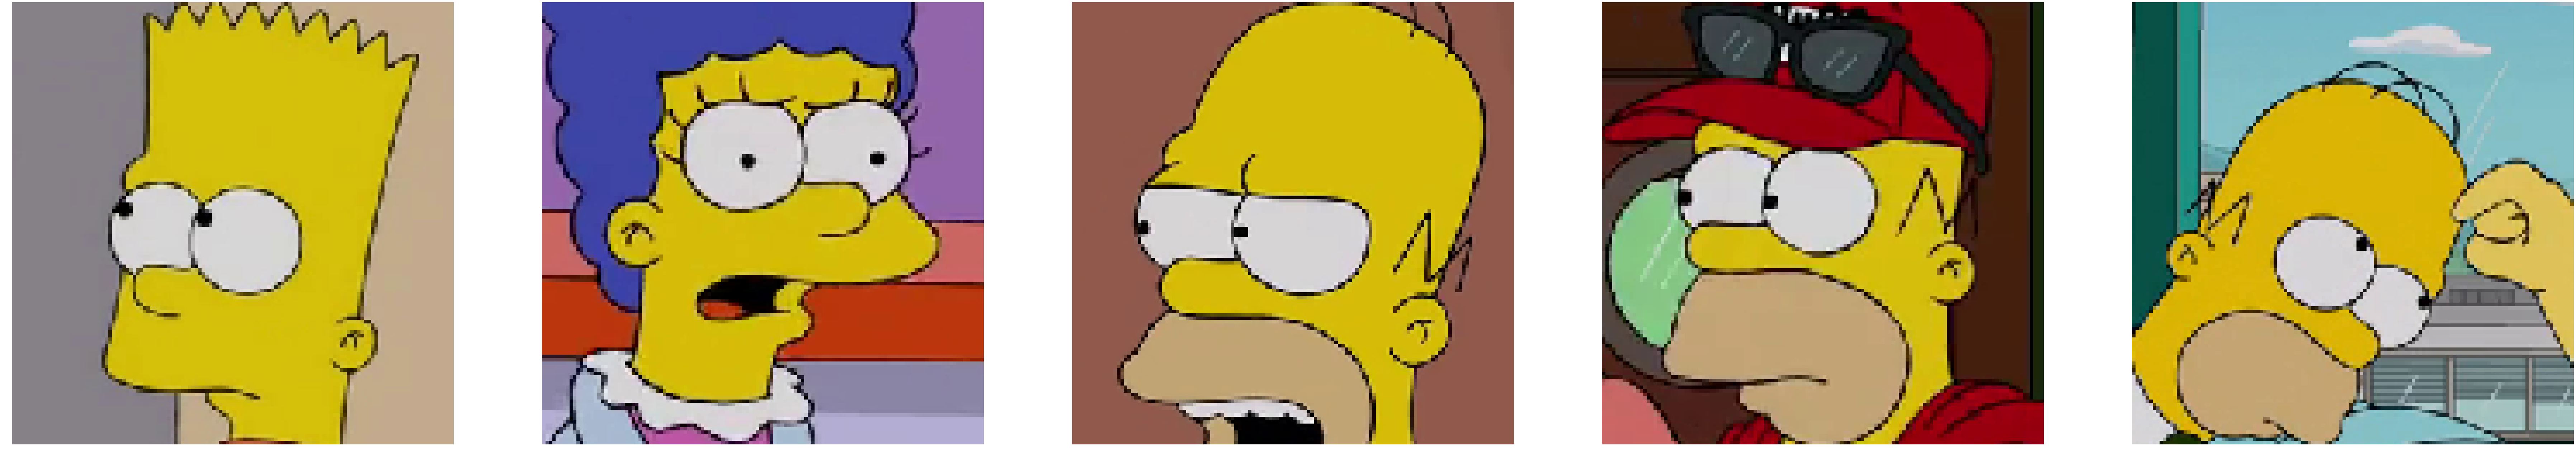

In [12]:
sample_images = random.sample(list(input_images), SAMPLES_TO_SHOW)
show_samples(sample_images, OUTPUT_DIR + "inputs", 0)

---------
Variables: name (type shape) [size]
---------
generator/dense/kernel:0 (float32_ref 100x65536) [6553600, bytes: 26214400]
generator/dense/bias:0 (float32_ref 65536) [65536, bytes: 262144]
generator/trans_conv1/kernel:0 (float32_ref 5x5x512x1024) [13107200, bytes: 52428800]
generator/trans_conv1/bias:0 (float32_ref 512) [512, bytes: 2048]
generator/batch_trans_conv1/gamma:0 (float32_ref 512) [512, bytes: 2048]
generator/batch_trans_conv1/beta:0 (float32_ref 512) [512, bytes: 2048]
generator/trans_conv2/kernel:0 (float32_ref 5x5x256x512) [3276800, bytes: 13107200]
generator/trans_conv2/bias:0 (float32_ref 256) [256, bytes: 1024]
generator/batch_trans_conv2/gamma:0 (float32_ref 256) [256, bytes: 1024]
generator/batch_trans_conv2/beta:0 (float32_ref 256) [256, bytes: 1024]
generator/trans_conv3/kernel:0 (float32_ref 5x5x128x256) [819200, bytes: 3276800]
generator/trans_conv3/bias:0 (float32_ref 128) [128, bytes: 512]
generator/batch_trans_conv3/gamma:0 (float32_ref 128) [128, byt

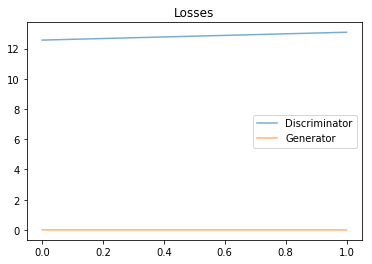

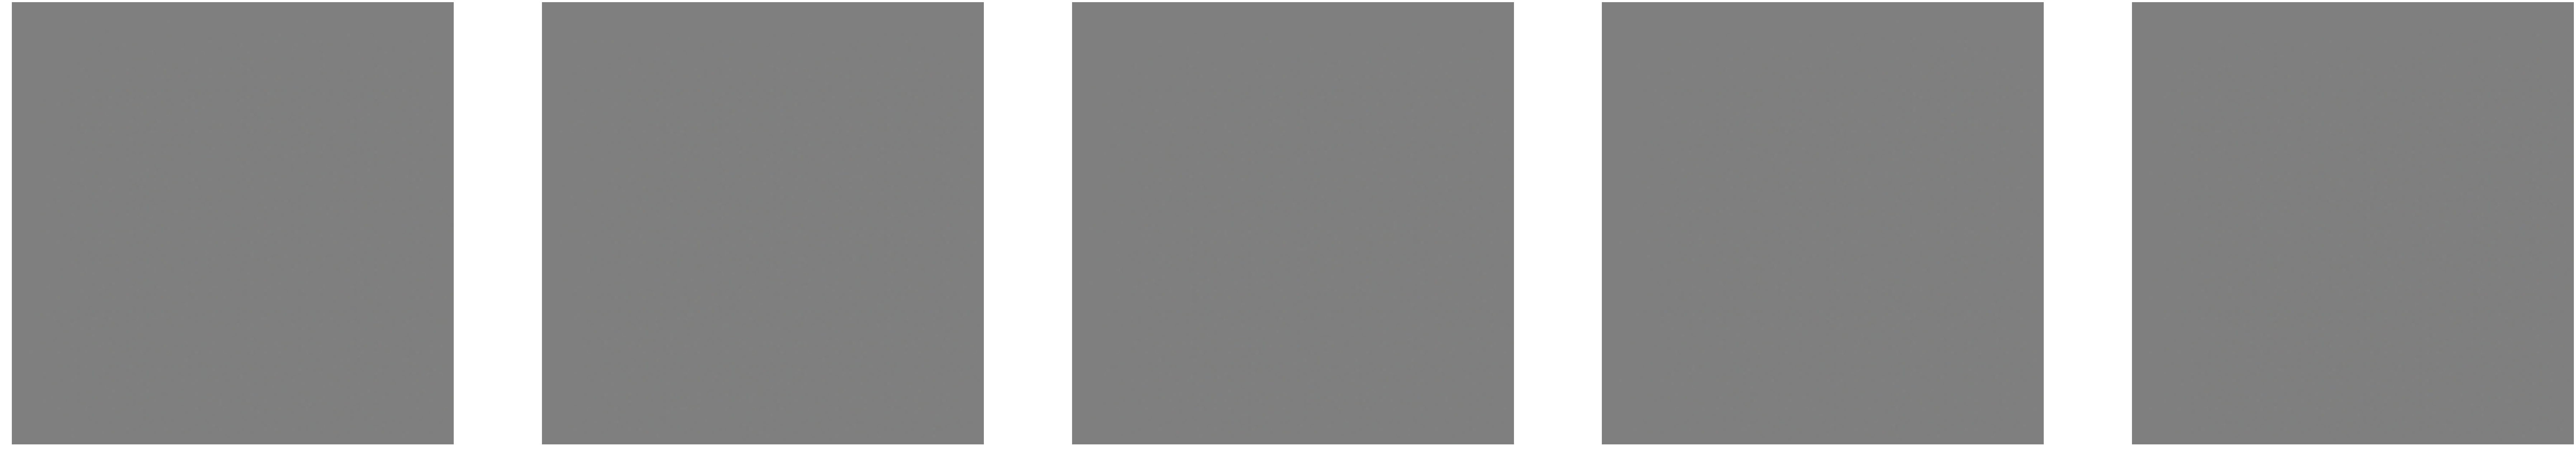

In [16]:
tf.reset_default_graph()
with tf.Graph().as_default():
    train(get_batches(small_images), small_images.shape)

In [ ]:
import tensorflow.contrib.slim as slim
def model_summary():
    model_vars = tf.trainable_variables()
    slim.model_analyzer.analyze_vars(model_vars, print_info=True)

model_summary()

In [26]:

def build_generator():

    model = Sequential()

    model.add(Dense(128 * 7 * 7, activation="relu", input_dim=100))
    model.add(Reshape((7, 7, 128)))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(Conv2D(1, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))

    model.summary()

    noise = Input(shape=(100,))
    img = model(noise)

    return Model(noise, img)

tg = build_generator()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
batch_normalization_10 (Batc (None, 14, 14, 128)       512       
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 128)       0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 28, 28, 128)       0         
__________

In [27]:
generator.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 65536)             6619136   
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 1024)        0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 1024)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 512)       13107712  
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 512)       2048      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 256)       3277056   
__________